# Portfolio Returns with S&P500 Constituents

## Setup

Install and important packages

In [1]:
# %pip install pandas_datareader
# %pip install yfinance
# #Run this code block twice if error
# # %pip install fix_yahoo_finance

In [2]:
import pandas as pd
from pandas_datareader import data as pdr # install via pip install pandas-datareader
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os

import yfinance as yf
yf.pdr_override()

### Define a function to calculate autocorrelations (for later use)

In [3]:
def autocorr(s):
    '''
    Calculate autocorrelation
    
    Parameters
    ----------
    s : pd.Series

    Returns
    -------
    float
    '''
    # drop missing observations
    s = s.dropna()
    
    # if enough data is available calculate and return autocorrelation, else return NAN
    if len(s) > 1:
        corr, pval = pearsonr(s[:-1], s[1:])
        return corr
    else:
        return np.NAN

## Load data

Load (adjusted) prices. Downloaded prices from Yahoo Finance and stored them in adj_price.csv. Download the file from Canvas so you can open them here.

In [4]:
# load adjusted prices from file
adj_price = pd.read_csv('adj_price.csv')

# format dates
adj_price['Date'] = pd.to_datetime(adj_price['Date'],format='%Y-%m-%d')
adj_price.set_index('Date',inplace=True)

In [5]:
# filename_tickers = 'sp500_constituents_june2019.csv'

# tickers = pd.read_csv(filename_tickers)
# tickers_yahoo = tickers['yahoo_ticker'].tolist()
# tickers_base = tickers['ticker'].tolist() 

# # choose your starting and ending time
# start = datetime.datetime(2019, 6, 28)
# end = datetime.datetime(2020, 6, 30)

# # grab prices for all tickers in ticker list
# adj_price = pdr.get_data_yahoo(tickers_yahoo, start=start, end=end)['Adj Close']

# # change tickers to 'base' tickers. We need to do this to merge the data with CRSP data later
# adj_price.rename(dict(zip(tickers_yahoo, tickers_base)),axis=1,inplace=True)

## Work with the data

In [6]:
# calculate simple returns
ret = adj_price.pct_change()

# show returns
# print(ret)

##  Question 1

a) Summary statistics

Moments of individual stocks

In [7]:
# mean, variance, standard deviation, skewness, kurtosis, autocorrelation
indv_stats = ret.aggregate(['mean','std','skew','kurt',autocorr]).T

In [8]:
# now calculate summary statistics for the individual stocks' moments ##
summ_stats_indv = indv_stats.describe(percentiles=[0.1,0.5,0.9])
summ_stats_indv.drop('count',inplace=True)

# print and save to file
print(summ_stats_indv)
summ_stats_indv.to_csv('summ_stats_indv.csv')

          mean       std      skew       kurt  autocorr
mean  0.000190  0.031972 -0.054544   8.040060 -0.139616
std   0.001068  0.009544  0.659788   4.216372  0.129781
min  -0.003840  0.015514 -2.061322   1.167578 -0.511316
10%  -0.001137  0.022733 -0.804924   3.822205 -0.312779
50%   0.000170  0.029332 -0.035370   7.004850 -0.133142
90%   0.001465  0.044100  0.638686  13.209999  0.023452
max   0.003943  0.074817  3.422080  45.487180  0.220307


b) Discuss findings



c) Plot stocks with the highest and lowest var

In [9]:
# Get the highest variance stock and lowest wariance stock
rank = ret.aggregate(['var']).T.sort_values('var', ascending=False).index.tolist()
highest_var_stock = rank[0]
lowest_var_stock = rank[-1]

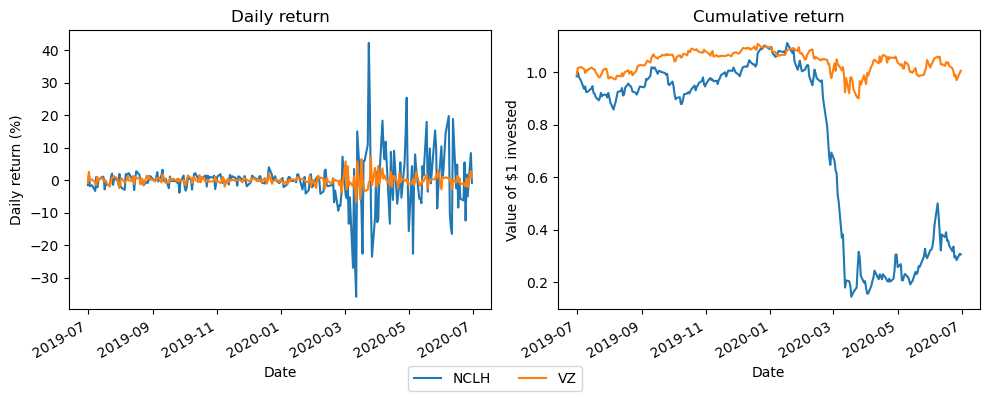

In [10]:
# make a plot
fig,axes = plt.subplots(1,2,figsize=[10,4])

# plot the portfolio returns in percent
ret_expl_high = ret.loc[:,highest_var_stock]
ret_expl_low = ret.loc[:,lowest_var_stock]
(ret_expl_high*100).plot(ax=axes[0])
(ret_expl_low*100).plot(ax=axes[0])

axes[0].set_ylabel('Daily return (%)')
axes[0].set_title('Daily return')
fig.legend(loc='lower center', ncol=2)

# plot the cumulative portfolio return (value of $1 invested in the portfolio at 'start')
ret_expl_cum_high = (1+ret_expl_high).cumprod()
ret_expl_cum_low = (1+ret_expl_low).cumprod()
ret_expl_cum_high.plot(ax=axes[1])
ret_expl_cum_low.plot(ax=axes[1])

axes[1].set_ylabel('Value of $1 invested')
axes[1].set_title('Cumulative return')

plt.tight_layout()
plt.savefig("q1_stock_returns.png", dpi=500)

## Question 2

Get market caps from CRSP (need these to form value-weighted portfolios)

In [11]:
# load from file
filename_mktcap = 'mktcap.csv'
mktcap = pd.read_csv(filename_mktcap)

# format dates
mktcap['date'] = pd.to_datetime(mktcap['date'],format='%Y-%m-%d')

In [12]:
# show data
# print(mktcap)

In [13]:
# pivot data
mktcap = mktcap.pivot(index='date',columns='ticker',values='mktcap')
# print(mktcap)

In [14]:
# align mktcap with returns
mktcap = mktcap.reindex(ret.index,axis=0)
mktcap = mktcap.reindex(ret.columns,axis=1)
# print(mktcap)

a) Form value-weighted portfolios

In [15]:
# build portfolios month-by-month
date_monthly = ret.index.to_period('M')
port = []
for datem in date_monthly.unique()[1:]: # skip the first month since it is incomplete
    ## prepare returns
    # grab returns for this month
    retm = ret.loc[date_monthly == datem]
    
    # cumulate gross returns (value of $1 invested at the beginning of the month)
    retm_cum = (1+retm).cumprod()
    
    # append a row of ones
    retm_cum.loc[retm_cum.index.min() - datetime.timedelta(days=1)] = 1
    retm_cum.sort_index(inplace=True)
    
    # only consider complete observations
    retm_cum.loc[:,retm_cum.count() != len(retm_cum)] = np.NAN
    
    
# =============================================================================
#     ## calculate portfolio returns
#     # value weights = invest in each stock proportional to its market capitalization
#     # since our data is end-of-day data, we need to use market caps from the last observation
#     #    at the end of the previous month
#     # grab last market cap of the previous month
    mktcap_eom = mktcap.loc[date_monthly == datem-1].iloc[-1]
#     
#     # weight cumulative returns by market cap, the a *= b means a = a*b, element by element
    retm_cum *= mktcap_eom
# =============================================================================

    # portfolio return
    # value of a portfolio of $1 invested in each stock 
    #    at the beginning of the month for each $1m dollars of market cap
    portm_cum = retm_cum.sum(axis=1)
    portm = portm_cum.pct_change()[1:]
    
    # store portfolio return in list
    port += [portm]

# stitch together monthly returns
port_mktcap = pd.concat(port,axis=0)

Plot portfolio returns

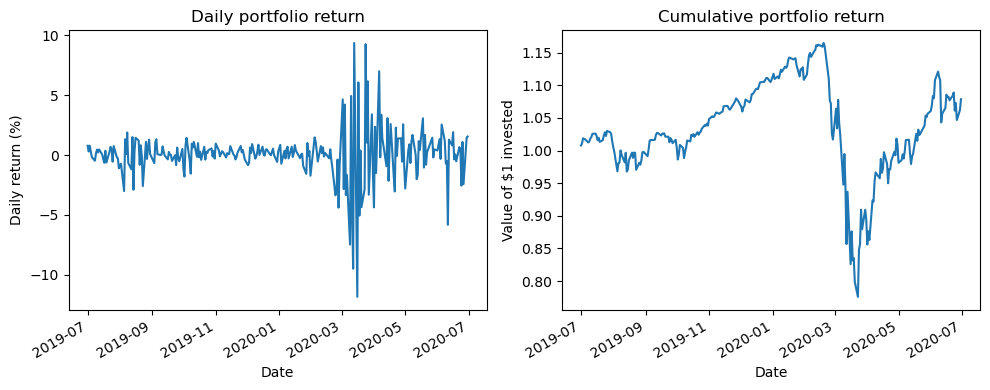

In [16]:
# make a plot
fig,axes = plt.subplots(1,2,figsize=[10,4])

# plot the portfolio returns in percent
port_pct = port_mktcap*100
port_pct.plot(ax=axes[0])

axes[0].set_ylabel('Daily return (%)')
axes[0].set_title('Daily portfolio return')

# plot the cumulative portfolio return (value of $1 invested in the portfolio at 'start')
port_cum = (1+port_mktcap).cumprod()
port_cum.plot(ax=axes[1])

axes[1].set_ylabel('Value of $1 invested')
axes[1].set_title('Cumulative portfolio return')
plt.tight_layout()
plt.savefig("q2_portfolio_returns.png", dpi=500)

b) Compare moments of portfolio returns with moments of individual stock returns

In [17]:
summ_stats_port = port_mktcap.aggregate(['mean','var','std','skew','kurt',autocorr])

# print and save to file
print(summ_stats_port)
summ_stats_port.to_csv('summ_stats_port.csv')

mean        0.000521
var         0.000441
std         0.020996
skew       -0.509193
kurt        9.129940
autocorr   -0.370333
dtype: float64


In [18]:
# compare with individual stock moment
print(summ_stats_indv)

          mean       std      skew       kurt  autocorr
mean  0.000190  0.031972 -0.054544   8.040060 -0.139616
std   0.001068  0.009544  0.659788   4.216372  0.129781
min  -0.003840  0.015514 -2.061322   1.167578 -0.511316
10%  -0.001137  0.022733 -0.804924   3.822205 -0.312779
50%   0.000170  0.029332 -0.035370   7.004850 -0.133142
90%   0.001465  0.044100  0.638686  13.209999  0.023452
max   0.003943  0.074817  3.422080  45.487180  0.220307


Discussion:



## Question 3

a) Form equal-weighted portfolio, plot returns, and make statistic summary 

In [19]:
# build portfolios month-by-month
date_monthly = ret.index.to_period('M')
port = []
for datem in date_monthly.unique()[1:]: # skip the first month since it is incomplete
    ## prepare returns
    # grab returns for this month
    retm = ret.loc[date_monthly == datem]
    
    # cumulate gross returns (value of $1 invested at the beginning of the month)
    retm_cum = (1+retm).cumprod()
    
    # append a row of ones
    retm_cum.loc[retm_cum.index.min() - datetime.timedelta(days=1)] = 1
    retm_cum.sort_index(inplace=True)
    
    # only consider complete observations
    retm_cum.loc[:,retm_cum.count() != len(retm_cum)] = np.NAN
    
    
# =============================================================================
#     ## calculate portfolio returns
#     # value weights = invest in each stock with equal weight
#     # weight 1/total number of stocks in the portfolio
#     # grab last market cap of the previous month
    num_of_stock = len(ret.axes[1]) # 471
    equal_weight = 1 / num_of_stock
     
#     # weight cumulative returns by equal weight, the a *= b means a = a*b, element by element
    retm_cum *= equal_weight
# =============================================================================

    # portfolio return
    # value of a portfolio of $1 invested in each stock 
    #    at the beginning of the month for each $1m dollars of market cap
    portm_cum = retm_cum.sum(axis=1)
    portm = portm_cum.pct_change()[1:]
    
    # store portfolio return in list
    port += [portm]

# stitch together monthly returns
port_equal = pd.concat(port,axis=0)

In [20]:
summ_stats_port_equal = port_equal.aggregate(['mean','var','std','skew','kurt',autocorr])

# print
print(summ_stats_port_equal)

mean        0.000122
var         0.000554
std         0.023532
skew       -0.550341
kurt        7.136939
autocorr   -0.213509
dtype: float64


In [21]:
# compare with individual stock moment
print(summ_stats_indv)

          mean       std      skew       kurt  autocorr
mean  0.000190  0.031972 -0.054544   8.040060 -0.139616
std   0.001068  0.009544  0.659788   4.216372  0.129781
min  -0.003840  0.015514 -2.061322   1.167578 -0.511316
10%  -0.001137  0.022733 -0.804924   3.822205 -0.312779
50%   0.000170  0.029332 -0.035370   7.004850 -0.133142
90%   0.001465  0.044100  0.638686  13.209999  0.023452
max   0.003943  0.074817  3.422080  45.487180  0.220307


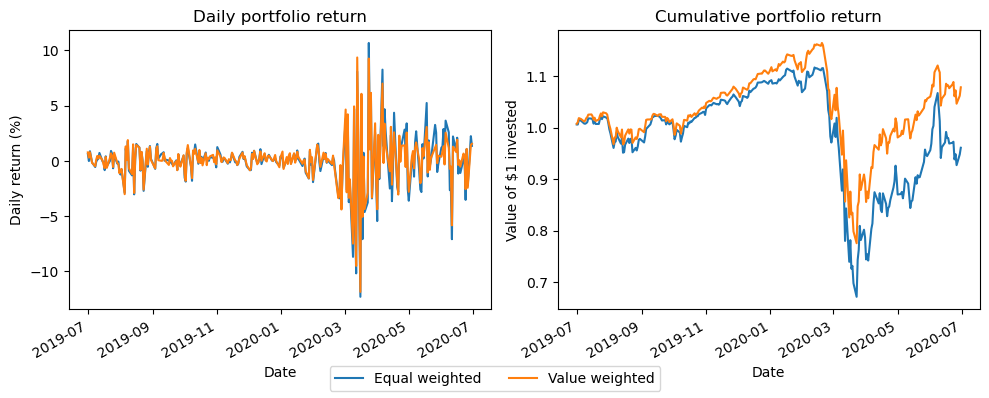

In [22]:
# make a plot
fig,axes = plt.subplots(1,2,figsize=[10,4])

# plot two portfolio returns in percent
port_pct_equal = port_equal*100
port_pct_equal.plot(ax=axes[0], label = 'Equal weighted')

port_pct_mktcap = port_mktcap*100
port_pct_mktcap.plot(ax=axes[0], label = 'Value weighted')

axes[0].set_ylabel('Daily return (%)')
axes[0].set_title('Daily portfolio return')
fig.legend(loc='lower center', ncol=2)

# plot the cumulative portfolio return (value of $1 invested in the portfolio at 'start')
port_cum_equal = (1+port_equal).cumprod()
port_cum_equal.plot(ax=axes[1])

port_cum_mktcap = (1+port_mktcap).cumprod()
port_cum_mktcap.plot(ax=axes[1])

axes[1].set_ylabel('Value of $1 invested')
axes[1].set_title('Cumulative portfolio return')
plt.tight_layout()
plt.savefig("q3_portfolios_returns.png", dpi=500)

Discussion:

b) Comparison between two methods：

## Bonus Question

In [23]:
date_monthly = ret.index.to_period('M')
port = []

for datem in date_monthly.unique()[1:]:  # skip the first month since it is incomplete
    # Prepare returns
    retm = ret.loc[date_monthly == datem]
    retm_cum = (1 + retm).cumprod()
    retm_cum.loc[retm_cum.index.min() - datetime.timedelta(days=1)] = 1
    retm_cum.sort_index(inplace=True)
    retm_cum.loc[:, retm_cum.count() != len(retm_cum)] = np.NaN

    # Calculate initial weights
    mktcap_eom = mktcap.loc[date_monthly == datem - 1].iloc[-1]
    total_mktcap = mktcap_eom.sum()
    initial_weights = mktcap_eom / total_mktcap

    # Apply 2% cap
    capped_weights = initial_weights.clip(upper=0.02)
    
    # Calculate the excess weight to be redistributed
    excess_weight = initial_weights[initial_weights > 0.02].sum() - capped_weights[capped_weights == 0.02].sum()

    # Redistribute weights to stocks under the cap
    redistribution_factor = capped_weights < 0.02
    capped_weights[redistribution_factor] += (capped_weights[redistribution_factor] / capped_weights[redistribution_factor].sum()) * excess_weight

    # Ensure weights sum up to 1 after redistribution
    capped_weights /= capped_weights.sum()

    # Weight cumulative returns by adjusted weights
    retm_cum_adjusted = retm_cum.mul(capped_weights, axis=1)
    portm_cum = retm_cum_adjusted.sum(axis=1)
    portm = portm_cum.pct_change()[1:]

    # Store portfolio return in list
    port += [portm]

# Stitch together monthly returns
port_mktcap_capped = pd.concat(port, axis=0)

In [24]:
# Calculate summary statistics
summ_stats_port_capped = port_mktcap_capped.aggregate(['mean', 'var', 'std', 'skew', 'kurt', lambda x: autocorr(x.dropna())])
summ_stats_port_capped.index = ['mean', 'var', 'std', 'skew', 'kurt', 'autocorr']

print(summ_stats_port_capped)

mean        0.000377
var         0.000445
std         0.021101
skew       -0.510645
kurt        8.972531
autocorr   -0.356423
dtype: float64
